In [2]:
%load_ext autoreload
%autoreload 2

import ast
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#import gensim
#from gensim.test.utils import get_tmpfile
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import json

%matplotlib inline

pd.set_option('display.max_columns', 500)

import pandas as pd 
import numpy as np 
import os
import re

import xgboost as xgb
import sklearn
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

# XGBoost model takes as input the features extracted by LSI

In [3]:
Y = np.load(r'y.npy')
X = np.load(r'LSI_features.npy')

In [4]:
print(X.shape)
print(Y.shape)

(488413, 300)
(488413,)


In [28]:
Y_LSI = Y[:50000]
X_LSI = X[:50000,:]

## Finetuning hyperparam. with subset of data

In [12]:
Y_LSI_tiny = Y[:5000]
X_LSI_tiny = X[:5000,:]

In [ ]:
regr = xgb.XGBRegressor(objective='reg:squarederror')

param_dist = {'max_depth':[4,5,6,7,8],  
                'min_child_weight':[4,5,6,7,8],
                'subsample':np.arange(0.90, 1.00, 0.01),
                'colsample_bytree': np.arange(0.30, 0.40, 0.01), 
                'colsample_bylevel': np.arange(0.65, 0.85, 0.01),
                'reg_alpha':[.001, .005, .0005],
                'reg_lambda':[.001, .005, .0005],
                }



# run randomized search
n_iter_search = 100
random_search = RandomizedSearchCV(regr, param_distributions=param_dist,
                                   n_iter=n_iter_search, cv=5, iid=False, 
                                   scoring='neg_mean_squared_error',
                                   n_jobs =-1,
                                   verbose=2)

random_search.fit(X_LSI_tiny,Y_LSI_tiny)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed: 13.2min


In [22]:
report(random_search.cv_results_, 5)

Model with rank: 1
Mean validation score: -0.924 (std: 0.054)
Parameters: {'subsample': 0.9800000000000001, 'reg_lambda': 0.0005, 'reg_alpha': 0.0005, 'min_child_weight': 5, 'max_depth': 4, 'colsample_bytree': 0.36000000000000004, 'colsample_bylevel': 0.65}

Model with rank: 2
Mean validation score: -0.937 (std: 0.058)
Parameters: {'subsample': 0.9700000000000001, 'reg_lambda': 0.0005, 'reg_alpha': 0.0005, 'min_child_weight': 7, 'max_depth': 4, 'colsample_bytree': 0.34, 'colsample_bylevel': 0.8100000000000002}

Model with rank: 3
Mean validation score: -0.942 (std: 0.056)
Parameters: {'subsample': 0.9600000000000001, 'reg_lambda': 0.001, 'reg_alpha': 0.0005, 'min_child_weight': 4, 'max_depth': 4, 'colsample_bytree': 0.34, 'colsample_bylevel': 0.8100000000000002}

Model with rank: 4
Mean validation score: -0.946 (std: 0.055)
Parameters: {'subsample': 0.91, 'reg_lambda': 0.0005, 'reg_alpha': 0.005, 'min_child_weight': 7, 'max_depth': 4, 'colsample_bytree': 0.35000000000000003, 'colsample

## XGB + LSI Performance CV-5

In [29]:
param = {'subsample': 0.9800000000000001, 
 'reg_lambda': 0.0005, 
 'reg_alpha': 0.0005, 
 'min_child_weight': 5, 
 'max_depth': 4, 
 'colsample_bytree': 0.36000000000000004, 
 'colsample_bylevel': 0.65,
 'n_jobs': -1}

                          
regr = xgboost.XGBRegressor(**param)

CV_LSI = cross_val_score(regr, X_LSI, Y_LSI, cv=5, scoring='neg_mean_squared_error',n_jobs=-1)

In [30]:
print("XGBoost + LSI, RMSE: ", -np.mean(CV_LSI), " +/- ", np.std(CV_LSI))

XGBoost + LSI, RMSE:  0.816566757370157  +/-  0.009217134999609126


## Baseline: dummy model

In [31]:
print("Constant Predictor, RMSE: ", np.std(Y_LSI) ** 2)

Constant Predictor, RMSE:  1.3335590000000002


## XGBoost model takes as input the features extracted by WORD2VEC

In [4]:
import numpy as np
from numpy.random import permutation
import time
import pandas as pd
import matplotlib.pyplot as plt
fw, fh = plt.rcParams["figure.figsize"]

from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.manifold import MDS, Isomap, LocallyLinearEmbedding, TSNE, SpectralEmbedding
from sklearn.metrics import silhouette_score, calinski_harabaz_score


import warnings
warnings.filterwarnings('ignore')

from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')


In [4]:
Y = np.load(r'y.npy')
X = np.load(r'WV_features.npy')
print(X.shape)
print(Y.shape)

(488413, 300)
(488413,)


In [5]:
Y_WV = Y[:50000]
X_WV = X[:50000,:]
Y_WV_tiny = Y[:5000]
X_WV_tiny = X[:5000,:]

In [12]:
#Xr = TSNE(n_components=ndim, n_iter=1000, init='pca',verbose=0).fit_transform(X)
Xr = TSNE(n_components=2, n_iter=250, verbose=1).fit_transform(X_WV)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 20000 samples in 0.481s...
[t-SNE] Computed neighbors for 20000 samples in 318.424s...
[t-SNE] Computed conditional probabilities for sample 1000 / 20000
[t-SNE] Computed conditional probabilities for sample 2000 / 20000
[t-SNE] Computed conditional probabilities for sample 3000 / 20000
[t-SNE] Computed conditional probabilities for sample 4000 / 20000
[t-SNE] Computed conditional probabilities for sample 5000 / 20000
[t-SNE] Computed conditional probabilities for sample 6000 / 20000
[t-SNE] Computed conditional probabilities for sample 7000 / 20000
[t-SNE] Computed conditional probabilities for sample 8000 / 20000
[t-SNE] Computed conditional probabilities for sample 9000 / 20000
[t-SNE] Computed conditional probabilities for sample 10000 / 20000
[t-SNE] Computed conditional probabilities for sample 11000 / 20000
[t-SNE] Computed conditional probabilities for sample 12000 / 20000
[t-SNE] Computed conditional probabilities for s

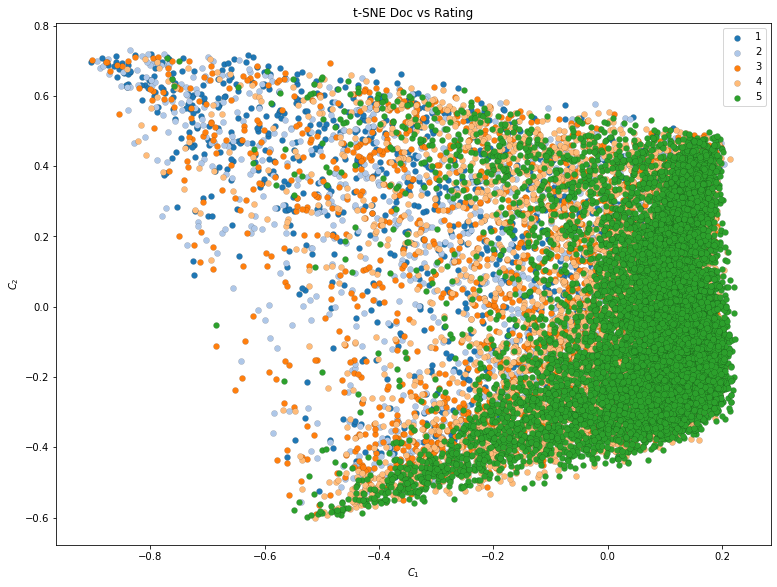

In [41]:
from plot_repr import plot_repr
fig, ax = plot_repr(Xr, Y_WV, title="t-SNE Doc vs Rating")
plt.show()

## RandomSearch

In [6]:
regr = xgb.XGBRegressor(objective='reg:squarederror')

param_dist = {'max_depth':[4,5,6,7,8],  
                'min_child_weight':[4,5,6,7,8],
                'subsample':np.arange(0.90, 1.00, 0.01),
                'colsample_bytree': np.arange(0.30, 0.40, 0.01), 
                'colsample_bylevel': np.arange(0.65, 0.85, 0.01),
                'reg_alpha':[.001, .005, .0005],
                'reg_lambda':[.001, .005, .0005],
                }



# run randomized search
n_iter_search = 100
random_search = RandomizedSearchCV(regr, param_distributions=param_dist,
                                   n_iter=n_iter_search, cv=5, iid=False, 
                                   scoring='neg_mean_squared_error',
                                   n_jobs =-1,
                                   verbose=2)

random_search.fit(X_WV_tiny,Y_WV_tiny)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   48.8s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 12.6min finished
D:\Users\MAGI\AppData\Local\Continuum\anaconda3\envs\tfcpu\lib\site-packages\sklearn\model_selection\_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, gamma=None,
                                          gpu_id=None, importance_type='gain',
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          n_...
                                        'colsample_bytree': array([0.3 , 0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 ]),
                                        'max_depth': [4

In [7]:
report(random_search.cv_results_, 5)

Model with rank: 1
Mean validation score: -0.838 (std: 0.024)
Parameters: {'subsample': 0.9800000000000001, 'reg_lambda': 0.0005, 'reg_alpha': 0.0005, 'min_child_weight': 8, 'max_depth': 4, 'colsample_bytree': 0.3, 'colsample_bylevel': 0.67}

Model with rank: 2
Mean validation score: -0.838 (std: 0.028)
Parameters: {'subsample': 0.9500000000000001, 'reg_lambda': 0.0005, 'reg_alpha': 0.001, 'min_child_weight': 6, 'max_depth': 4, 'colsample_bytree': 0.37000000000000005, 'colsample_bylevel': 0.7300000000000001}

Model with rank: 3
Mean validation score: -0.840 (std: 0.032)
Parameters: {'subsample': 0.9500000000000001, 'reg_lambda': 0.005, 'reg_alpha': 0.0005, 'min_child_weight': 8, 'max_depth': 4, 'colsample_bytree': 0.32, 'colsample_bylevel': 0.67}

Model with rank: 4
Mean validation score: -0.842 (std: 0.017)
Parameters: {'subsample': 0.9600000000000001, 'reg_lambda': 0.001, 'reg_alpha': 0.0005, 'min_child_weight': 6, 'max_depth': 4, 'colsample_bytree': 0.35000000000000003, 'colsample_b

## XGB + W2V

In [9]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
param = {'subsample': 0.9800000000000001, 
         'reg_lambda': 0.0005, 
         'reg_alpha': 0.0005, 
         'min_child_weight': 8, 
         'max_depth': 4, 
         'colsample_bytree': 0.3, 
         'colsample_bylevel': 0.67,
         'n_jobs': -1}
                          
regr = xgb.XGBRegressor(**param)

CV_W2V = cross_val_score(regr, X_WV, Y_WV, cv=5, scoring='neg_mean_squared_error',n_jobs=-1)

In [10]:
print("XGBoost + Word2Vec, RMSE: ", -np.mean(CV_W2V), " +/- ", np.std(CV_W2V))

XGBoost + Word2Vec, RMSE:  0.7017732273356262  +/-  0.006321441325429483


## XGBoost model takes as input the features extracted by FastText

In [11]:
Y = np.load(r'y.npy')
X = np.load(r'FT_features.npy')
print(X.shape)
print(Y.shape)

Y_FT = Y[:50000]
X_FT = X[:50000,:]
Y_FT_tiny = Y[:5000]
X_FT_tiny = X[:5000,:]

(488413, 300)
(488413,)


In [12]:
regr = xgb.XGBRegressor(objective='reg:squarederror')

param_dist = {'max_depth':[4,5,6,7,8],  
                'min_child_weight':[4,5,6,7,8],
                'subsample':np.arange(0.90, 1.00, 0.01),
                'colsample_bytree': np.arange(0.30, 0.40, 0.01), 
                'colsample_bylevel': np.arange(0.65, 0.85, 0.01),
                'reg_alpha':[.001, .005, .0005],
                'reg_lambda':[.001, .005, .0005],
                }


# run randomized search
n_iter_search = 100
random_search = RandomizedSearchCV(regr, param_distributions=param_dist,
                                   n_iter=n_iter_search, cv=5, iid=False, 
                                   scoring='neg_mean_squared_error',
                                   n_jobs =-1,
                                   verbose=2)

random_search.fit(X_FT_tiny,Y_FT_tiny)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   55.2s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed: 10.7min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 15.4min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, gamma=None,
                                          gpu_id=None, importance_type='gain',
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          n_...
                                        'colsample_bytree': array([0.3 , 0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 ]),
                                        'max_depth': [4

In [13]:
report(random_search.cv_results_, 5)

Model with rank: 1
Mean validation score: -1.590 (std: 0.039)
Parameters: {'subsample': 0.9700000000000001, 'reg_lambda': 0.005, 'reg_alpha': 0.001, 'min_child_weight': 7, 'max_depth': 4, 'colsample_bytree': 0.39000000000000007, 'colsample_bylevel': 0.7600000000000001}

Model with rank: 2
Mean validation score: -1.600 (std: 0.063)
Parameters: {'subsample': 0.9800000000000001, 'reg_lambda': 0.0005, 'reg_alpha': 0.0005, 'min_child_weight': 8, 'max_depth': 4, 'colsample_bytree': 0.31, 'colsample_bylevel': 0.8300000000000002}

Model with rank: 3
Mean validation score: -1.605 (std: 0.059)
Parameters: {'subsample': 0.92, 'reg_lambda': 0.0005, 'reg_alpha': 0.0005, 'min_child_weight': 6, 'max_depth': 4, 'colsample_bytree': 0.31, 'colsample_bylevel': 0.8100000000000002}

Model with rank: 4
Mean validation score: -1.606 (std: 0.026)
Parameters: {'subsample': 0.92, 'reg_lambda': 0.0005, 'reg_alpha': 0.005, 'min_child_weight': 4, 'max_depth': 4, 'colsample_bytree': 0.39000000000000007, 'colsample_

## XGB + FastText

In [19]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
param = {'subsample': 0.9700000000000001, 
         'reg_lambda': 0.005, 
         'reg_alpha': 0.001, 
         'min_child_weight': 7, 
         'max_depth': 4, 
         'colsample_bytree': 0.39000000000000007, 
         'colsample_bylevel': 0.7600000000000001,
        'n_jobs': -1}
                          
regr = xgb.XGBRegressor(**param)
#regr = xgb.XGBRegressor()
CV_FT = cross_val_score(regr, X_FT, Y_FT, cv=5, scoring='neg_mean_squared_error',n_jobs=-1)

In [20]:
print("XGBoost + FastText, RMSE: ", -np.mean(CV_FT), " +/- ", np.std(CV_FT))

XGBoost + FastText, RMSE:  1.3985589268624892  +/-  0.017065956135353243
